Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.


### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from glob import glob

from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

In [3]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.



In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
train_path = "/content/drive/MyDrive/Melanoma_assignment_v1/Train"
test_path = "/content/drive/MyDrive/Melanoma_assignment_v1/Test"
data_dir_train = pathlib.Path(train_path)
data_dir_test = pathlib.Path(test_path)

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Train image count = ", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Test image count = ", image_count_test)

Train image count =  2239
Test image count =  118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training',
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [10]:
img_dict = {}
for root, dir, file in os.walk(train_path):
  if not dir:
    name = str(root).split('/')[-1]
    img_dict[name] = len(file)
    print("Number of images for", name,  "=", len(file))

Number of images for dermatofibroma = 95
Number of images for basal cell carcinoma = 376
Number of images for pigmented benign keratosis = 462
Number of images for squamous cell carcinoma = 181
Number of images for melanoma = 438
Number of images for vascular lesion = 139
Number of images for seborrheic keratosis = 77
Number of images for actinic keratosis = 114
Number of images for nevus = 357


<BarContainer object of 9 artists>

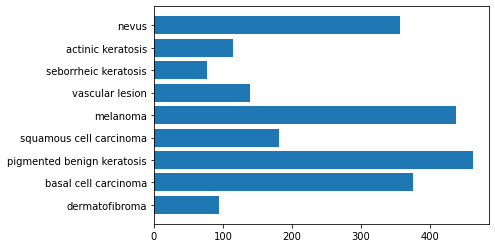

In [11]:
plt.barh(list(img_dict.keys()), list(img_dict.values()))

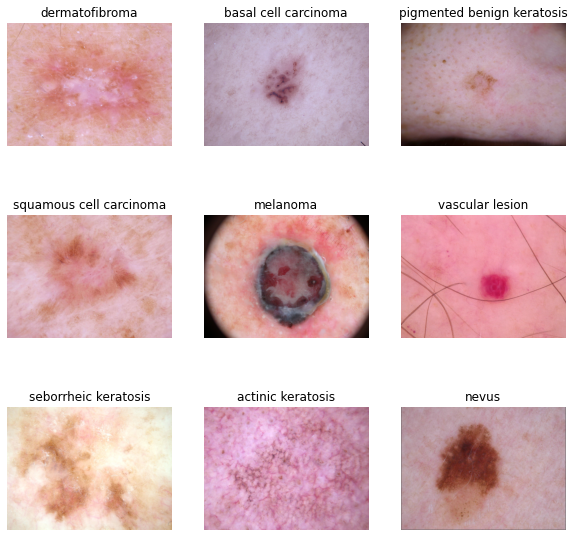

In [12]:
plt.figure(figsize=(10,10))
num=0
for root, dirs, files in os.walk(train_path):
    if not dirs:
      for filename in [f for f in files if f.endswith(".jpg")][:1]:
        img = PIL.Image.open(str(root)+"/"+str(filename))

        plt.subplot(3,3,num+1)
        plt.title(str(root).split('/')[-1])
        plt.axis('off')
        plt.imshow(img)
        num=num+1

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

## Model 1 : Layers without dropout

In [14]:
model=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),
    Conv2D(32, (3,3), input_shape=(img_height,img_width,3), activation = 'relu', padding = 'same'),

    Conv2D(32, (3,3), activation = 'relu'),
    BatchNormalization(),
    
    Conv2D(32, (3,3), activation = 'relu', padding = 'same'),

    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(pool_size = (2,2)),
    
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(pool_size = (2,2)),
    
    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(pool_size = (2,2)),

    Flatten(),

    Dense(128, activation='relu'),
   
    Dense(9, activation='softmax')
])


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [15]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam', metrics = ['accuracy'])

### Train the model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 285s 1s/step - loss: 1.9380 - accuracy: 0.3292 - val_loss: 2.1889 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 9s 157ms/step - loss: 1.5170 - accuracy: 0.4743 - val_loss: 2.1350 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 9s 159ms/step - loss: 1.3943 - accuracy: 0.5078 - val_loss: 2.1482 - val_accuracy: 0.0738
Epoch 4/20
56/56 [==============================] - 9s 162ms/step - loss: 1.2433 - accuracy: 0.5502 - val_loss: 2.0976 - val_accuracy: 0.2819
Epoch 5/20
56/56 [==============================] - 9s 164ms/step - loss: 1.1436 - accuracy: 0.5938 - val_loss: 1.7359 - val_accuracy: 0.4027
Epoch 6/20
56/56 [==============================] - 9s 162ms/step - loss: 1.0604 - accuracy: 0.6239 - val_loss: 1.7827 - val_accuracy: 0.3803
Epoch 7/20
56/56 [==============================] - 9s 161ms/step - loss: 0.8288 - accuracy: 0.7243 - val_loss: 1.7538 - val_accuracy: 0.4161
Epoch 8

### Visualizing training results

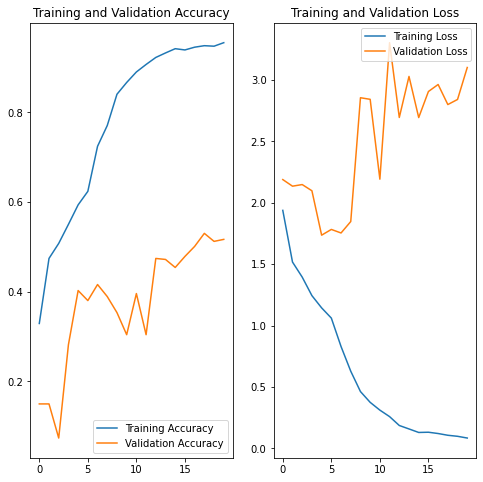

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observations from "Model 1 - Layers without dropout"

Train accuracy - 83%

Validation accuracy - 51%

Model has overfitted on training data and hence it has high accuracy for training data, and low accuracy for validation data.

## Model 2 - Layers with dropout

In [19]:
model2=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),
    Conv2D(32, (3,3), input_shape=(img_height,img_width,3), activation = 'relu', padding = 'same'),
    Dropout(0.2),

    Conv2D(32, (3,3), activation = 'relu'),
    BatchNormalization(),
    Dropout(0.1),
    
    Conv2D(32, (3,3), activation = 'relu', padding = 'same'),

    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(pool_size = (2,2)),
    Dropout(0.2),
    
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(pool_size = (2,2)),
    Dropout(0.2),

    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(pool_size = (2,2)),
    Dropout(0.2),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.2),
  
    Dense(9, activation='softmax')
])


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [20]:

model2.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam', metrics = ['accuracy'])

### Train the model

In [21]:
epochs = 20
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 11s 186ms/step - loss: 2.8544 - accuracy: 0.2059 - val_loss: 2.1892 - val_accuracy: 0.2103
Epoch 2/20
56/56 [==============================] - 10s 184ms/step - loss: 1.9090 - accuracy: 0.2500 - val_loss: 2.1421 - val_accuracy: 0.3624
Epoch 3/20
56/56 [==============================] - 10s 183ms/step - loss: 1.7550 - accuracy: 0.3359 - val_loss: 2.1137 - val_accuracy: 0.3020
Epoch 4/20
56/56 [==============================] - 10s 184ms/step - loss: 1.6222 - accuracy: 0.4090 - val_loss: 2.0214 - val_accuracy: 0.4049
Epoch 5/20
56/56 [==============================] - 10s 180ms/step - loss: 1.6245 - accuracy: 0.4146 - val_loss: 1.9253 - val_accuracy: 0.4877
Epoch 6/20
56/56 [==============================] - 10s 183ms/step - loss: 1.4960 - accuracy: 0.4688 - val_loss: 1.7886 - val_accuracy: 0.4116
Epoch 7/20
56/56 [==============================] - 10s 182ms/step - loss: 1.4476 - accuracy: 0.4994 - val_loss: 1.6166 - val_accuracy: 0.5145

### Visualizing training results

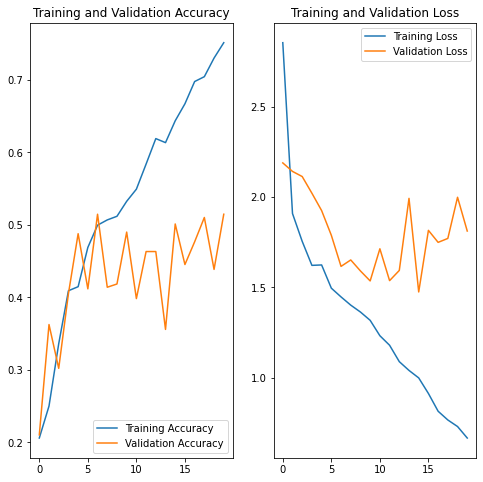

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Observation from "Model 2 - Layers with dropout"

Train accuracy - 75%

Validation accuracy - 51%

Overfitting on train data has reduced due to dropouts, but still this model have low accuracy and not the ideal one.

## Model 3 - Use image augmentation

In [23]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.

#### Sample augmentation

In [24]:

data_augmentation=tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomContrast(0.2),
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


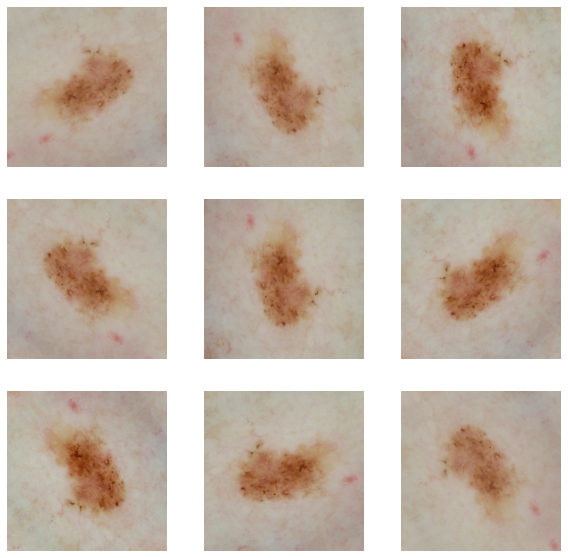

In [25]:
image, label = next(iter(train_ds))
image=np.array(image,np.int32)  
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  augmented_image1=np.array(augmented_image[0],np.int32)  
  plt.imshow((augmented_image1))
  plt.axis("off")

#### Balance each class - Create 500 samples of each class with image augmentation

In [26]:
path_to_training_dataset=train_path
import Augmentor
for i in class_names:
    path = path_to_training_dataset + "/" + i
    p = Augmentor.Pipeline(path)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) 

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma_assignment_v1/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F7FE53E01D0>: 100%|██████████| 500/500 [00:21<00:00, 23.38 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma_assignment_v1/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F7FE54DB8D0>: 100%|██████████| 500/500 [00:22<00:00, 22.32 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma_assignment_v1/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7FE5426E50>: 100%|██████████| 500/500 [00:20<00:00, 24.47 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma_assignment_v1/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7F7FE53F3A50>: 100%|██████████| 500/500 [01:29<00:00,  5.58 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma_assignment_v1/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7F7FE53C6CD0>: 100%|██████████| 500/500 [01:22<00:00,  6.04 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma_assignment_v1/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7FE54DB510>: 100%|██████████| 500/500 [00:19<00:00, 25.85 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma_assignment_v1/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F7FE53F3A50>: 100%|██████████| 500/500 [00:43<00:00, 11.54 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma_assignment_v1/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F7FE52EBC10>: 100%|██████████| 500/500 [00:19<00:00, 26.23 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma_assignment_v1/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7FE8652FD0>: 100%|██████████| 500/500 [00:19<00:00, 25.57 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [27]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [28]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list[:10]

['/content/drive/MyDrive/Melanoma_assignment_v1/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031344.jpg_c96e495b-27a7-4f12-a3f0-23c57554c0f1.jpg',
 '/content/drive/MyDrive/Melanoma_assignment_v1/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029578.jpg_6398f2af-95c5-49cd-bcc8-a4adb5f886ea.jpg',
 '/content/drive/MyDrive/Melanoma_assignment_v1/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026313.jpg_e5dc62b6-27dd-433c-9d73-1f28aa3aa4fa.jpg',
 '/content/drive/MyDrive/Melanoma_assignment_v1/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033808.jpg_61f0c61e-6579-4af6-b018-a08fd49ba75b.jpg',
 '/content/drive/MyDrive/Melanoma_assignment_v1/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026313.jpg_f91c6ab2-bbb4-4264-ac86-acf08cae8d9f.jpg',
 '/content/drive/MyDrive/Melanoma_assignment_v1/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033695.jpg_92568528-6d88-4b82-93ed-14cdddffb248.jpg',
 '/content/drive/MyDrive/Melanoma_assign

In [29]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:10]

['dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma']

In [30]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [46]:

for i in class_names:
    directory =train_path+i+'/'
    directory_out =train_path +'/' +i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob('*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    print(f'{i} = {length_tot} samples.')

actinic keratosis = 500 samples.
basal cell carcinoma = 500 samples.
dermatofibroma = 500 samples.
melanoma = 500 samples.
nevus = 500 samples.
pigmented benign keratosis = 500 samples.
seborrheic keratosis = 500 samples.
squamous cell carcinoma = 500 samples.
vascular lesion = 500 samples.


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo:** Create a training dataset

In [33]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [48]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Creating the Model

In [49]:
model_final=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
    
    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

### Compiling the Model

In [50]:
model_final.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics='accuracy')

### Train the Model

In [51]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model_final.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 31s 172ms/step - loss: 2.3045 - accuracy: 0.2264 - val_loss: 1.7356 - val_accuracy: 0.3734
Epoch 2/30
169/169 [==============================] - 30s 170ms/step - loss: 1.5670 - accuracy: 0.4112 - val_loss: 1.5188 - val_accuracy: 0.4202
Epoch 3/30
169/169 [==============================] - 29s 169ms/step - loss: 1.3880 - accuracy: 0.4870 - val_loss: 1.3309 - val_accuracy: 0.5033
Epoch 4/30
169/169 [==============================] - 30s 169ms/step - loss: 1.2058 - accuracy: 0.5595 - val_loss: 1.1200 - val_accuracy: 0.6021
Epoch 5/30
169/169 [==============================] - 29s 168ms/step - loss: 1.0585 - accuracy: 0.6233 - val_loss: 1.1070 - val_accuracy: 0.5969
Epoch 6/30
169/169 [==============================] - 30s 170ms/step - loss: 0.9556 - accuracy: 0.6521 - val_loss: 0.9826 - val_accuracy: 0.6370
Epoch 7/30
169/169 [==============================] - 29s 169ms/step - loss: 0.8000 - accuracy: 0.7064 - val_loss: 0.8888 - val_ac

### Visualizing the model results

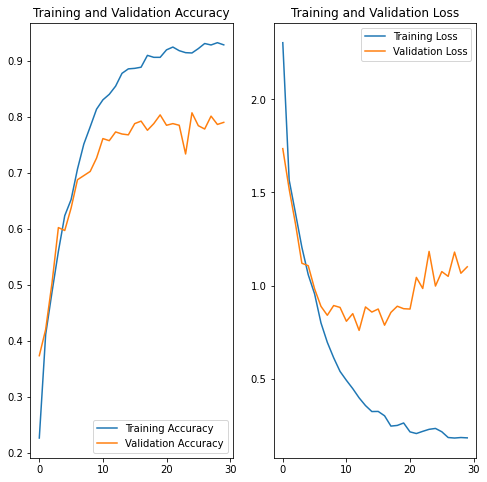

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings - Model 3 with image augmentation

Train accuracy - 92%

Validation accuracy - 78%

Here, class imbalanced was handled by augmenting images. Also, this time 30 epochs were used. This model gave quite a good accuracy and can be used to detect Melanoma cancer.

For better accuracy -  
1. Handle imbalanced class
2. Use more epochs
3. Create more layers and add dropouts